# 프로젝트: 멋진 작사가 만들기

## 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 데이터 다운로드
이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

## Step 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [2]:
import glob
import os, re

import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


In [3]:
raw_corpus

['',
 '',
 '[Spoken Intro:]',
 'You ever want something ',
 "that you know you shouldn't have ",
 "The more you know you shouldn't have it, ",
 'The more you want it ',
 'And then one day you get it, ',
 "It's so good too ",
 "But it's just like my girl ",
 "When she's around me ",
 'I just feel so good, so good ',
 'But right now I just feel cold, so cold ',
 'Right down to my bones ',
 "'Cause ooh... ",
 "Ain't no sunshine when she's gone ",
 "It's not warm when she's away ",
 "Ain't no sunshine when she's gone ",
 "And she's always gone too long ",
 'Anytime she goes away ',
 '',
 "Wonder this time where she's gone ",
 "Wonder if she's gone to stay ",
 "Ain't no sunshine when she's gone ",
 "And this house just ain't no home ",
 'Anytime she goes away ',
 '',
 'I know, I know, I know, I know, ',
 'I know, know, know, know, know, ',
 'I know, I know, ',
 'Hey I ought to leave ',
 'I ought to leave her alone ',
 "Ain't no sunshine when she's gone ",
 '',
 "Ain't no sunshine when she's

## Step 3. 데이터 정제
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [5]:
# 여기에 정제된 문장을 모음
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    if sentence.count(' ') >= 14: continue # 토큰의 개수가 15개를 넘어가는 문장을 제외
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

In [6]:
len(corpus) # 165986개의 문장이 정제된 것을 확인

165986

## Step 4. 평가 데이터셋 분리
훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [7]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer 구현
    # 우리는 이미 문장을 정제했으니 filters가 필요없음
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 변경
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, #단어장의 크기는 12000
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춤
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2741 2474 ...    0    0    0]
 [   2    7  161 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2   42    6 ...    0    0    0]
 [   2   31    7 ...    0    0    0]
 [   2  310    1 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fe07bb54100>


In [8]:
# 구축된 단어 사전을 확인(10번째 순서까지)
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [9]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

In [10]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [11]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (132788, 19)
Target Train:  (132788, 19)


In [12]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 12000개로 선언했기 때문에, tokenizer.num_words의 값은 12000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만들기
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Step 5. 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.
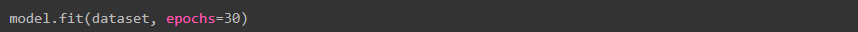
하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

In [14]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
#문장을 토큰으로 했을 때 19이므로 19로 구성했습니다.
embedding_size = 19 # 워드 벡터의 차원수 - 단어가 추상적으로 표현되는 크기
hidden_size = 2048 # 모델에 둘 일꾼수

# tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

In [16]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어보기(모델의 summary 확인용)
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[ 6.36967670e-05, -6.47089400e-05, -4.24972714e-05, ...,
          7.71199921e-05, -1.61544285e-05, -2.21736191e-05],
        [ 6.85276827e-05, -8.08537297e-05, -6.80570593e-05, ...,
          1.66230442e-04, -1.28255881e-04, -3.68542969e-05],
        [ 5.09821402e-05, -1.44665319e-04, -3.53110117e-05, ...,
          9.19061931e-05, -2.28975419e-04,  4.56549606e-05],
        ...,
        [-7.93900908e-05,  2.63213878e-04,  3.01955035e-04, ...,
         -2.56466505e-04, -9.32848779e-05,  4.07287764e-04],
        [-1.39418495e-04,  3.11574811e-04,  3.38402053e-04, ...,
         -2.55924650e-04, -1.55939560e-04,  4.66857804e-04],
        [-1.94718261e-04,  3.44000553e-04,  3.71195638e-04, ...,
         -2.60200148e-04, -2.18893867e-04,  5.21410722e-04]],

       [[ 6.36967670e-05, -6.47089400e-05, -4.24972714e-05, ...,
          7.71199921e-05, -1.61544285e-05, -2.21736191e-05],
        [ 1.24969476e-04, -1.13358001e-04,  1

In [17]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  228019    
_________________________________________________________________
lstm (LSTM)                  multiple                  16941056  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 75,321,748
Trainable params: 75,321,748
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=64,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
2075/2075 [==============================] - 437s 209ms/step - loss: 2.6359 - val_loss: 2.3555
Epoch 2/10
2075/2075 [==============================] - 429s 207ms/step - loss: 2.2675 - val_loss: 2.2110
Epoch 3/10
2075/2075 [==============================] - 415s 200ms/step - loss: 2.1079 - val_loss: 2.1117
Epoch 4/10
2075/2075 [==============================] - 415s 200ms/step - loss: 1.9574 - val_loss: 2.0342
Epoch 5/10
2075/2075 [==============================] - 419s 202ms/step - loss: 1.8006 - val_loss: 1.9733
Epoch 6/10
2075/2075 [==============================] - 415s 200ms/step - loss: 1.6433 - val_loss: 1.9255
Epoch 7/10
2075/2075 [==============================] - 415s 200ms/step - loss: 1.4924 - val_loss: 1.8940
Epoch 8/10
2075/2075 [==============================] - 415s 200ms/step - loss: 1.3540 - val_loss: 1.8779
Epoch 9/10
2075/2075 [==============================] - 416s 200ms/step - loss: 1.2305 - val_loss: 1.8716
Epoch 10/10
2075/2075 [=======================

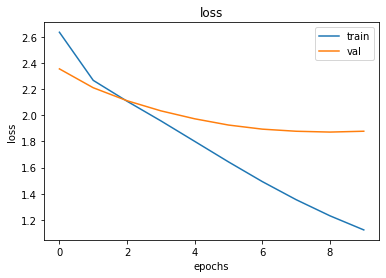

In [49]:
import matplotlib.pyplot as plt
y = history.history['loss']
plt.plot(history.epoch, history.history['loss'], label="train")
plt.plot(history.epoch, history.history['val_loss'], label="val")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [51]:
#문장생성 함수
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
#시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받음
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): 
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만들기
    #    1. 입력받은 문장의 텐서를 입력
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아내기
    #    3. 2에서 예측된 word index를 문장 뒤에 붙이기
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마침(도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [52]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you , i love you <end> '

## 프로젝트 결과 및 회고
- 이번 프로젝트는 NLP 계열 프로젝트로 txt 파일을 불러와 학습시키고 키워드를 입력하였을 때 어떤 답을 반환하는지에 대한 프로젝트 입니다.
- 우선 txt 형식의 파일을 불러와서 리스트에 문장을 저장한 후 전처리 과정을 통해 데이터를 정제하였습니다. 이과정에서 특수문자를 제거하고, 너무 길이가 긴 문장(15단어 이상)은 제외하도록 설정하였습니다. 정제된 데이터셋을 가지고 적용을 하기 위해서 훈련 데이터셋과 평가 데이터셋을 8:2로 분리하였습니다. 그리고 lstm의 하이퍼 파라미터를 수정하여 구현하였으며 이를 통해 구현된 모델의 val_loss값을 구해보았습니다. 10epoch 안에 val_loss값이 2.2 이하가 되는 것이 목표인데 3 epoch만에 2.2 이하로 떨어지는 것을 확인할 수 있었습니다. 
- 마지막으로 제가 만든 모델에 특정 키워드(i love)만 입력하였을때 i love you, i love you라는 답을 받을 수 있었습니다.
- 한 번 수행하는데 많은 시간이 걸려 optimizer를 adam이 아닌 RMSProp로 바꾸거나 오버피팅 방지 기법을 사용하는 등의 시도는 하지 못한 것이 아쉽고 제출한 후에 로컬에서 동일한 프로젝트를 진행해보며 못해본 실험을 해볼 예정입니다.
    - 로컬 환경에서 프로젝트 진행해보는 것이 필요하니 꼭 해볼 것